<a href="https://colab.research.google.com/github/n-bzy/iannwtf/blob/main/homework_08_silvie.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tqdm
import tensorflow as tf
import tensorflow_datasets as tfds

#downloading the mnist dataset (we will only use the inputs)
(x_train, t_train), (x_test, t_test) = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 1s 0us/step


# Preprocessing
Instead of using the original mnist inputs (handwritten digit) and targets (digit labels), we want to map the **noisy image version (input)** to the **original image (target)**.

In [2]:
def preprocess(img):
  """Preprocessing the training and testing data for the autoencoder"""
  #add 3rd dimension, change datatype to float, normalize
  img_preprocessed = tf.cast(tf.expand_dims(img,-1), tf.float32)/255.
  #shuffle, batch, prefetch
  #img_preprocessed = img_preprocessed.shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)
  return img_preprocessed

def noise(img, noise_factor = 0.5):
  """Applies noise to image, noise amount is regulated by hyperparameter noise_factor"""
  #add noise to image
  img_noisy = img + noise_factor * tf.random.normal(mean=0.0, stddev=1.0, shape=img.shape)
  #keep img within [0,1]-scale by clipping outliers to min/max value
  img_noisy = tf.clip_by_value(img_noisy,0.0,1.0)
  return img_noisy

In [3]:
#create data pipeline
train_ds = tf.data.Dataset.from_tensor_slices((x_train, x_train))
test_ds = tf.data.Dataset.from_tensor_slices((x_test, x_test))

#preprocess data
train_ds = train_ds.map(lambda x,t: (noise(preprocess(x)), preprocess(t))).shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.map(lambda x,t: (noise(preprocess(x)), preprocess(t))).shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)

# Plot input and target examples

In [4]:
def plot(noisy_input,target,n=5):
  """Function to plot the first n input and prediction/target image pairs"""
  #create empty plot
  plt.figure()
  #iterate over first n data input-target/prediction pairs
  for i in range(n):
    #add input img as subplot
    plt.subplot(2, n, i+1)
    plt.title("input")
    plt.imshow(tf.squeeze(noisy_input[i])) #remove/squeeze 3rd dimension for plotting
    #hide axis
    plt.axis('off')
    #add prediction/target as subplot
    plt.subplot(2, n, n+i+1)
    plt.title("target")
    plt.imshow(tf.squeeze(target[i])) #remove/squeeze 3rd dimension for plotting
    #hide axis
    plt.axis('off')
  #show plot
  plt.show()

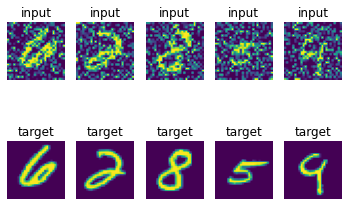

In [5]:
#show 5 examples
for i,t in train_ds:
  plot(i,t)
  break

# Convolutional Autoencoder
Autoencoder model contains 2 parts: <br>
**Encoder**: Input image gets mapped to a flat embedding space.<br>
**Decoder**: Image gets reconstructed from flat embedding space.

In [9]:
class Encoder(tf.keras.Model):
  """Independent Encoder Model"""
  def __init__(self, embedding_size):
    super(Encoder, self).__init__()
    #subsample twice to a size of 7x7
    self.layer1 = tf.keras.layers.Conv2D(filters=64,kernel_size=3,strides=2,padding='same',activation='relu')
    self.layer2 = tf.keras.layers.Conv2D(filters=128,kernel_size=3,strides=2,padding='same',activation='relu')
    #flatten the feature maps
    self.flat = tf.keras.layers.Flatten()
    #use bottleneck dense layer construct to produce an embedding of specified size
    self.bottleneck_in = tf.keras.layers.Dense(7*7*128, activation='relu')
    self.embedding = tf.keras.layers.Dense(embedding_size)

  @tf.function
  def __call__(self,x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.flat(x)
        x = self.bottleneck_in(x)
        x = self.embedding(x)
        return x


class Decoder(tf.keras.Model):
  """Independent Decoder Model"""
  def __init__(self):
    super(Decoder, self).__init__()
    #reconstruct dimensionality of flattened feature maps to bottleneck input size
    self.bottleneck_out = tf.keras.layers.Dense(7*7*128, activation='relu')
    #reshape vector into feature maps
    self.reshape = tf.keras.layers.Reshape((7,7,128))
    #mirror encoder by using transposed convolutions
    self.transpose1 =  tf.keras.layers.Conv2DTranspose(128, kernel_size=3, strides=2, padding='same', activation='relu')
    self.transpose2 =  tf.keras.layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding='same', activation='relu')
    #produce output image
    self.out = tf.keras.layers.Conv2D(1,kernel_size=3,strides=1,padding='same',activation='sigmoid')

  @tf.function
  def __call__(self,x):
    x = self.bottleneck_out(x)
    x = self.reshape(x)
    x = self.transpose1(x)
    x = self.transpose2(x)
    y = self.out(x)
    return y


class ConvAutoencoder(tf.keras.Model):
  """Full Concolutional Autoencoder Model that contains Encoder and Decoder via subclassing"""
  def __init__(self, embedding_size):
    super(ConvAutoencoder, self).__init__()
    #autoencoder consists of encoder and decoder
    self.encoder = Encoder(embedding_size)
    self.decoder = Decoder()
    #specify metrics, optimizer, loss function
    self.metrics_list = [tf.keras.metrics.Mean(name="loss")]
    self.optimizer = tf.keras.optimizers.Adam()
    self.loss = tf.keras.losses.MeanSquaredError()
  
  @tf.function
  def __call__(self,x,training=False):
    x = self.encoder(x)
    y = self.decoder(x)
    return y
  
  @tf.function
  def train(self,data):
    x,t = data
    with tf.GradientTape() as tape:
        y = self(x, training=True)
        loss = self.loss(t, y)
    gradients = tape.gradient(loss, self.trainable_variables)
    self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
    self.metrics[0].update_state(loss)
    return {m.name : m.result() for m in self.metrics}
  
  @tf.function
  def test(self,data):
    x,t = data
    y = self(x, training=False)
    loss = self.loss(t, y)
    self.metrics[0].update_state(loss)
    return {m.name : m.result() for m in self.metrics} 


# Training

In [10]:
def training_loop(model, train, val, epochs):
    """Train and test the RNN for given epochs on given data"""

    # Save loss and accuracy as dictionaries in a list for visualization
    lists = []

    for n in range(epochs):
        print(f"Epoch {n}:")

        for data in tqdm.tqdm(train, position=0, leave=True):
            metrics = model.train(data)

        # Add metrics to list
        lists.append(metrics)
        print([f"{key}: {value.numpy()}" for (key,value) in metrics.items()])
        model.reset_metrics()

        for data in tqdm.tqdm(val, position=0, leave=True):
            metrics = model.test(data)

        # Add metrics to list
        lists.append(metrics)
        print([f"{key}: {value.numpy()}" for (key,value) in metrics.items()])
        model.reset_metrics()
        
    return lists

In [11]:
#initialize model
model = ConvAutoencoder(embedding_size=10)
#train network
li = training_loop(model, train_ds, test_ds, epochs=15)

Epoch 0:


100%|██████████| 1875/1875 [00:31<00:00, 59.69it/s]


['loss: 0.11245560646057129']


100%|██████████| 313/313 [00:01<00:00, 209.49it/s]


['loss: 0.11397222429513931']
Epoch 1:


100%|██████████| 1875/1875 [00:23<00:00, 78.30it/s]


['loss: 0.11200263351202011']


100%|██████████| 313/313 [00:01<00:00, 270.00it/s]


['loss: 0.11395740509033203']
Epoch 2:


100%|██████████| 1875/1875 [00:23<00:00, 79.58it/s]


['loss: 0.1120026484131813']


100%|██████████| 313/313 [00:01<00:00, 247.83it/s]


['loss: 0.11396260559558868']
Epoch 3:


100%|██████████| 1875/1875 [00:23<00:00, 79.21it/s]


['loss: 0.11200255900621414']


100%|██████████| 313/313 [00:01<00:00, 276.69it/s]


['loss: 0.11398810148239136']
Epoch 4:


100%|██████████| 1875/1875 [00:23<00:00, 78.89it/s]


['loss: 0.11200248450040817']


100%|██████████| 313/313 [00:01<00:00, 279.13it/s]


['loss: 0.11393525451421738']
Epoch 5:


100%|██████████| 1875/1875 [00:23<00:00, 79.17it/s]


['loss: 0.11200251430273056']


100%|██████████| 313/313 [00:01<00:00, 276.28it/s]


['loss: 0.11397510766983032']
Epoch 6:


100%|██████████| 1875/1875 [00:23<00:00, 79.03it/s]


['loss: 0.11200255900621414']


100%|██████████| 313/313 [00:01<00:00, 212.00it/s]


['loss: 0.1139669343829155']
Epoch 7:


100%|██████████| 1875/1875 [00:23<00:00, 78.83it/s]


['loss: 0.11200248450040817']


100%|██████████| 313/313 [00:01<00:00, 278.44it/s]


['loss: 0.11400460451841354']
Epoch 8:


100%|██████████| 1875/1875 [00:23<00:00, 79.05it/s]


['loss: 0.11200255900621414']


100%|██████████| 313/313 [00:01<00:00, 277.29it/s]


['loss: 0.1139732226729393']
Epoch 9:


100%|██████████| 1875/1875 [00:23<00:00, 79.12it/s]


['loss: 0.11200255900621414']


100%|██████████| 313/313 [00:01<00:00, 268.91it/s]


['loss: 0.11396384984254837']
Epoch 10:


100%|██████████| 1875/1875 [00:23<00:00, 79.20it/s]


['loss: 0.1120026633143425']


100%|██████████| 313/313 [00:01<00:00, 276.00it/s]


['loss: 0.11396180093288422']
Epoch 11:


100%|██████████| 1875/1875 [00:23<00:00, 79.54it/s]


['loss: 0.06882424652576447']


100%|██████████| 313/313 [00:01<00:00, 281.71it/s]


['loss: 0.02171998657286167']
Epoch 12:


100%|██████████| 1875/1875 [00:23<00:00, 80.23it/s]


['loss: 0.018964583054184914']


100%|██████████| 313/313 [00:01<00:00, 278.64it/s]


['loss: 0.017642715945839882']
Epoch 13:


100%|██████████| 1875/1875 [00:23<00:00, 80.24it/s]


['loss: 0.016856906935572624']


100%|██████████| 313/313 [00:01<00:00, 268.55it/s]


['loss: 0.016345586627721786']
Epoch 14:


100%|██████████| 1875/1875 [00:23<00:00, 80.55it/s]


['loss: 0.01597251184284687']


100%|██████████| 313/313 [00:01<00:00, 280.01it/s]

['loss: 0.015847139060497284']


# Loss visualization

In [12]:
def visualization(lists):
    """Visualizes accuracy and loss for training and test data """

    # Create lists for each visualized metric
    epochs = np.array([*range(15)])
    train_loss = np.zeros(epochs.size)
    test_loss = np.zeros(epochs.size)

    # Counter used for splitting the input
    c,i = 0,0
    # Split up the metrics to the corresponding arrays
    for k in range(len(lists)):
        if k%2 == 1:
            test_loss[i] = lists[k]['loss'].numpy()
            i += 1
        else:
            train_loss[c] = lists[k]['loss'].numpy()
            c += 1
    
    # Create dictionary with all metrics
    data= {'Train_Loss':train_loss, 'Test_Loss':test_loss}

    # Plot the metrics
    sns.set_theme()
    sns.relplot(data=data, kind='line').set(title='Visualization of loss',xlabel='Epochs', ylabel='Loss')


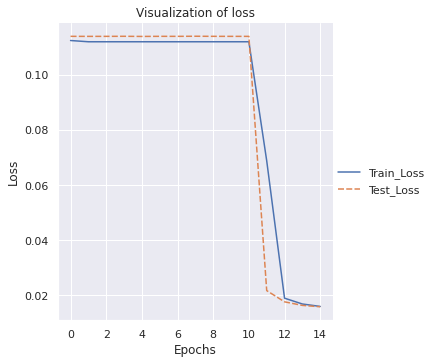

In [13]:
visualization(li)